In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
import calendar
import random
import seaborn as sns
import numpy as np
import itertools
import warnings
warnings.filterwarnings("ignore")

In [2]:
conn = psycopg2.connect(
  port='5432',
  host= "shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com",
  user= "softtouchlenses_4e0b7c925f8444429457581f35678aea",
  password="softtouchlenses_4e0b7c925f8444429457581f35678aea_password",
  database= "softtouchlenses_4e0b7c925f8444429457581f35678aea_db"
)

In [3]:
query1 = """select o.id as order_id,
            o.created_at::date as order_date,
            o.customer_id as user_id,
            oli.product_id as product_id,
            oli.name as product_name,
            o.total_price as order_amount,
            CASE
        WHEN cancelled_at IS NOT NULL THEN 'Cancelled'
         ELSE 'Delivered'
     END as order_status,
            oli.quantity as quantity,
            oli.price as sp
            from orders o
            join order_line_item oli on oli.order_id = o.id"""

In [4]:
data = pd.read_sql(query1, conn)

In [5]:
data["order_date"] = pd.to_datetime(data["order_date"])
data[data["product_id"] == np.nan]
data = data.dropna()
data['WeekCount']=data['order_date'].dt.strftime('%Y-w%U')
data=data.sort_values('order_date')
WeekList=data['WeekCount'].unique()

In [6]:
WeekList = WeekList.tolist()
output_list = []

for i in range(len(WeekList) - 1):
    output_list.append(WeekList[i])
    current_week = int(WeekList[i].split('-w')[1])
    next_week = int(WeekList[i + 1].split('-w')[1])
    missing_weeks = next_week - current_week - 1
    for j in range(1, missing_weeks + 1):
        missing_week = current_week + j
        output_list.append(f'{WeekList[i][:5]}w{missing_week:02d}')

output_list.append(WeekList[-1])

In [7]:
orderuserlevel=data.groupby(['order_id','user_id']).agg(
          order_date=pd.NamedAgg(column='order_date', aggfunc='min'),

    ).reset_index()
orderuserlevel=orderuserlevel.sort_values('order_date')
orderuserlevel['TrxnRank'] = orderuserlevel.groupby('user_id')['order_date'].rank(method='first')
orderuserlevel


data=pd.merge(data,
         orderuserlevel[['order_id','TrxnRank']],
         on="order_id",
         how ='left')
data['New']=0
data['Repeat']=0
data.loc[data['TrxnRank']==1,'New']=1
data.loc[data['TrxnRank']>1,'Repeat']=1

#AOV Contribution
data['ordervalue']=data['quantity']*data['sp']
data['AOVContribution']=data['ordervalue']/data["order_id"].nunique()
data['DeltaDaysinOrders']=(data.groupby('user_id').order_date.shift() - data.order_date).dt.days.abs()
data['DeltaOrderValues']=(data.groupby('user_id').ordervalue.shift() - data.ordervalue)

In [8]:
Weekly_Stats = {}
productsegstats_weekly = {}
user_cohort_labels = ['New', 'Churned (Single Use Only)', 'Recent & Loyals', 'Champions', 'Churned (Repeat Use)']
user_cohort_var_list = ['Users']#, 'Orders', 'Recency', 'AOVContribution', 'OrderValue','MeanDaysDelta', 'MeanOVDelta', 'Maturity', 'Frequency', 'AOV'
product_cohort_labels=['Hero', 'High Value & Slow Moving', 'Low Value & Slow Moving', 'New Business Drivers', 'Repeat Business Drivers']
product_cohort_var_list=['ProductCount'] #'Orders','Users','AverageSellingPrice','QuantityperCart','CartPenetration','NewUserRatio','NewOrders','ASPXQpC','AOVContribution','ProductCountMix','OrdersMix','UsersMix','AOVContribution(%)','OrderPerSKU'
final_stats = pd.DataFrame()

for x in output_list:
  x3 = data[data['WeekCount'] <= x]
  try:
    userweeklydata = x3.groupby("user_id").agg(
          Last_Date=pd.NamedAgg(column='order_date', aggfunc= lambda x: x.nlargest(2).min()),
          First_Date=pd.NamedAgg(column='order_date', aggfunc='min'),
          OrdersCount=pd.NamedAgg(column='order_id', aggfunc='nunique'),
          Frequency=pd.NamedAgg(column='order_id', aggfunc='nunique'),
          Order_Value=pd.NamedAgg(column='ordervalue', aggfunc='sum'),
          #Mean_Days_Delta=pd.NamedAgg(column='DeltaDaysinOrders', aggfunc='mean'),
          #Mean_OV_Delta=pd.NamedAgg(column='DeltaOrderValues', aggfunc='mean')
          ).reset_index()

    globalmaxdateweek=x3['order_date'].max()
    userweeklydata['Recency']=globalmaxdateweek-userweeklydata['Last_Date']
    userweeklydata['Recency']=userweeklydata['Recency'].dt.days.abs()
    userweeklydata['MaturityAge']=np.nan
    userweeklydata.loc[userweeklydata['Frequency']>1,"MaturityAge"]=(userweeklydata['Last_Date']-userweeklydata['First_Date']).dt.days.abs()
    #userweeklydata['Mean_Days_Delta']=userweeklydata['Mean_Days_Delta'].fillna(0)
    #userweeklydata['Mean_OV_Delta']=userweeklydata['Mean_OV_Delta'].fillna(0)
    userweeklydata['Customer_AOV']=userweeklydata['Order_Value']/userweeklydata['OrdersCount']

    r_labels, f_labels,AOV_labels, m_labels,DelAOV_labels = range(4, 0, -1), range(1,5), range(1,5),range(1,5),range(1,5)
    #userweeklydata['f_score'] = userweeklydata['OrdersCount'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = f_labels)).astype('int64')
    userweeklydata['r_score'] = userweeklydata['Recency'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = r_labels)).astype('int64')
   # userweeklydata['AOV_score'] = userweeklydata['Customer_AOV'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = AOV_labels)).astype('int64')
    userweeklydata['m_score']=0
    userweeklydata.loc[userweeklydata['MaturityAge'].notnull(),'m_score']= userweeklydata.loc[userweeklydata['MaturityAge'].notnull()]['MaturityAge'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = m_labels)).astype('int64')
    #userweeklydata['DelAOV'] = userweeklydata['Mean_OV_Delta'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = DelAOV_labels)).astype('int64')
    #userweeklydata['SumScore'] = userweeklydata['r_score'] + userweeklydata['m_score'] + userweeklydata['AOV_score']+ userweeklydata['DelAOV'] +userweeklydata['f_score']
    def CohortLables_3(df):
      if ((df['Frequency']==1) & (df['r_score']>2)):
          return "New"
      elif ((df['Frequency'] == 1) & (df['r_score'] <= 2)):
          return 'Churned (Single Use Only)'
      elif ((df['Frequency'] > 1) & (df['m_score'] < 3) & (df['r_score'] >2)):
          return 'Recent & Loyals'
      elif ((df['Frequency'] > 1) & (df['m_score'] >=3) & (df['r_score'] > 2)):
          return 'Champions'
      else:
          return 'Churned (Repeat Use)'
    userweeklydata['User_Cohort_Label'] = userweeklydata.apply(CohortLables_3, axis=1)
    x3=pd.merge(x3,
         userweeklydata[['user_id','User_Cohort_Label']],
         on="user_id",
         how ='left')

    totalcarts=x3['order_id'].nunique()
    productlevel=x3.groupby(['product_id','product_name']).agg(
              Carts=pd.NamedAgg(column='order_id', aggfunc='nunique'),
              quantity=pd.NamedAgg(column='quantity', aggfunc='sum'),
              ASP=pd.NamedAgg(column='sp', aggfunc='mean'),
              NewOrders=pd.NamedAgg(column='New', aggfunc='sum'),
              RepeatOrders=pd.NamedAgg(column='Repeat', aggfunc='sum'),
              Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
              AOVContribution=pd.NamedAgg(column='AOVContribution', aggfunc='sum'),
        ).reset_index()
    productlevel['CartPenetration']=productlevel['Carts']/totalcarts
    productlevel['NewUserRatio']=productlevel['NewOrders']/productlevel['Users']
    productlevel['QpC']=productlevel['quantity']/productlevel['Carts']
    productlevel['ASPXQpC']=productlevel['ASP']*productlevel['QpC']

    CP_labels, NewRatio_labels,ASP_labels, QpC_labels =  range(1,5), range(1,5),range(1,5),range(1,5)

    productlevel['CP_score'] = productlevel['CartPenetration'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = CP_labels)).astype('int64')
    productlevel['NewRatio_score'] = productlevel['NewUserRatio'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = NewRatio_labels)).astype('int64')
    productlevel['ASP_score'] = productlevel['ASP'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = ASP_labels)).astype('int64')
    productlevel['QpC_score'] = productlevel['QpC'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = QpC_labels)).astype('int64')
    productlevel['SumScore'] = productlevel['CP_score'] + productlevel['NewRatio_score'] + productlevel['ASP_score'] + productlevel['QpC_score']

    def ProductCohortLables2(df):
      if ((df['CP_score']>2) and (df['NewRatio_score'] >3)):
          return 'New Business Drivers'
      elif ((df['CP_score'] >2) and (df['NewRatio_score'] <2)):
          return 'Repeat Business Drivers'
      elif (df['CP_score'] >2):
          return 'Hero'
      elif (df['ASP_score'] >3):
          return 'High Value & Slow Moving'
      elif (df['ASP_score'] <=3):
          return 'Low Value & Slow Moving'
      else:
          return 'Low Value & Slow Moving'

    productlevel['Product Cohort Lables'] = productlevel.apply(ProductCohortLables2, axis=1)
    x3=pd.merge(x3,
         productlevel[['product_id','Product Cohort Lables']],
         on="product_id",
         how ='left')


    User_Product_Level=x3.groupby(['User_Cohort_Label','Product Cohort Lables']).agg(
        Order_Value=pd.NamedAgg(column='ordervalue', aggfunc='sum'),
            Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
        Order_Count=pd.NamedAgg(column='order_id', aggfunc='nunique'),

    ).reset_index()

    Weekly_Stats[x] = User_Product_Level
    x4 = data[data['WeekCount']==x]
    x5 = pd.merge(x4,userweeklydata[['user_id','User_Cohort_Label']], on='user_id', how='left')
    x5 = pd.merge(x5,productlevel[['product_id','Product Cohort Lables']], on='product_id', how='left')
    final_stats = final_stats.append(x5, ignore_index=True)


  except:
    pass


In [9]:
final_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31105 entries, 0 to 31104
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   order_id               31105 non-null  int64         
 1   order_date             31105 non-null  datetime64[ns]
 2   user_id                31105 non-null  int64         
 3   product_id             31105 non-null  float64       
 4   product_name           31105 non-null  object        
 5   order_amount           31105 non-null  float64       
 6   order_status           31105 non-null  object        
 7   quantity               31105 non-null  int64         
 8   sp                     31105 non-null  float64       
 9   WeekCount              31105 non-null  object        
 10  TrxnRank               31105 non-null  float64       
 11  New                    31105 non-null  int64         
 12  Repeat                 31105 non-null  int64         
 13  o

In [10]:
final_stats.to_csv("Toffee_final_stats.csv")

In [11]:
final_stats

,order_id,order_date,user_id,product_id,product_name,order_amount,order_status,quantity,sp,WeekCount,TrxnRank,New,Repeat,ordervalue,AOVContribution,DeltaDaysinOrders,DeltaOrderValues,User_Cohort_Label,Product Cohort Lables
0,3965604233390,2021-08-17,5422063714478,7.253512e+12,Affaires Color Yearly Contact Lenses Three Ton...,1000.0,Cancelled,1,1000.0,2021-w33,1.0,1,0,1000.0,0.396354,NaN,NaN,Churned (Single Use Only),Hero
1,3969073283246,2021-08-19,5425893015726,7.251689e+12,Affaires Magnetic Reading Spectacle Glasses Fo...,599.0,Delivered,1,599.0,2021-w33,1.0,1,0,599.0,0.237416,NaN,NaN,New,Low Value & Slow Moving
2,3969315209390,2021-08-19,5426204672174,7.253567e+12,SOFLENS 59 - BAUSCH & LOMB (Monthly) (6 Lenses...,899.0,Delivered,1,899.0,2021-w33,1.0,1,0,899.0,0.356322,NaN,NaN,Churned (Single Use Only),New Business Drivers
3,3969532985518,2021-08-19,5426393317550,7.253349e+12,Affaires Clear UV Contact Lenses Yearly Dispos...,600.0,Cancelled,1,600.0,2021-w33,1.0,1,0,600.0,0.237812,NaN,NaN,Churned (Single Use Only),Low Value & Slow Moving
4,3969532985518,2021-08-19,5426393317550,7.253349e+12,Affaires Clear UV Contact Lenses Yearly Dispos...,600.0,Cancelled,1,600.0,2021-w33,1.0,1,0,600.0,0.237812,NaN,NaN,Churned (Single Use Only),Low Value & Slow Moving
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31100,5231961374894,2023-12-15,6773256618158,7.253438e+12,Affaires Color Yearly Contact Lenses Two Tone ...,900.0,Delivered,1,900.0,2023-w50,1.0,1,0,900.0,0.356718,NaN,NaN,New,Low Value & Slow Moving
31101,5231961374894,2023-12-15,6773256618158,7.253438e+12,Affaires Color Yearly Contact Lenses Two Tone ...,900.0,Delivered,1,900.0,2023-w50,1.0,1,0,900.0,0.356718,NaN,NaN,New,Low Value & Slow Moving
31102,5231961374894,2023-12-15,6773256618158,7.253438e+12,Affaires Color Yearly Contact Lenses Two Tone ...,900.0,Delivered,1,900.0,2023-w50,1.0,1,0,900.0,0.356718,NaN,NaN,New,Low Value & Slow Moving
31103,5231961374894,2023-12-15,6773256618158,7.253438e+12,Affaires Color Yearly Contact Lenses Two Tone ...,900.0,Delivered,1,900.0,2023-w50,1.0,1,0,900.0,0.356718,NaN,NaN,New,Hero


In [12]:
final_stats["User_Cohort_Label"].unique()

array(['Churned (Single Use Only)', 'New', 'Recent & Loyals', 'Champions',
       'Churned (Repeat Use)'], dtype=object)

In [13]:
#AOV Contribution
final_stats['ordervalue']=final_stats['ordervalue']
final_stats['AOVContribution']=final_stats['ordervalue']/final_stats["order_id"].nunique()
final_stats['DeltaDaysinOrders']=(final_stats.groupby('user_id').order_date.shift() - final_stats.order_date).dt.days.abs()
final_stats['DeltaOrderValues']=(final_stats.groupby('user_id').ordervalue.shift() - final_stats.ordervalue)
weekly_summary_stats = final_stats.groupby(['WeekCount','User_Cohort_Label','Product Cohort Lables']).agg(
            totalorders=pd.NamedAgg(column='order_id', aggfunc='nunique'),
            totalusers=pd.NamedAgg(column='user_id', aggfunc='nunique'),
            totalvalue=pd.NamedAgg(column='ordervalue', aggfunc='sum'),
            quantity=pd.NamedAgg(column='quantity', aggfunc='sum'),
            SKUCounts=pd.NamedAgg(column='product_id', aggfunc='nunique')
      ).reset_index()
newdf=final_stats[final_stats['New']==1].groupby(['WeekCount','User_Cohort_Label','Product Cohort Lables']).agg(
    newusercount=pd.NamedAgg(column='user_id', aggfunc='nunique'),
     ).reset_index()
cancelled_orders = final_stats[final_stats['order_status'] == 'Cancelled'].groupby(['WeekCount','User_Cohort_Label','Product Cohort Lables']).agg(
    CancellationCount=pd.NamedAgg(column='order_id', aggfunc='count')
).fillna(0).reset_index()

delivered_orders = final_stats[final_stats['order_status'] == 'Delivered'].groupby(['WeekCount','User_Cohort_Label','Product Cohort Lables']).agg(
    DeliveryCount=pd.NamedAgg(column='order_id', aggfunc='count')
).fillna(0).reset_index()
weekly_summary_stats = weekly_summary_stats.merge(newdf, on=['WeekCount','User_Cohort_Label','Product Cohort Lables'], how="left")
weekly_summary_stats =weekly_summary_stats.merge(cancelled_orders, on=['WeekCount','User_Cohort_Label','Product Cohort Lables'], how="left")
weekly_summary_stats = weekly_summary_stats.merge(delivered_orders, on=['WeekCount','User_Cohort_Label','Product Cohort Lables'], how="left")
weekly_summary_stats['repeatusercount']=weekly_summary_stats['totalusers']-weekly_summary_stats['newusercount']
weekly_summary_stats['AOV'] = weekly_summary_stats['totalvalue']/ weekly_summary_stats['totalorders']


In [14]:
final_stats["Retention"] = 0
final_stats.loc[(final_stats["DeltaDaysinOrders"] > 0) & (final_stats["DeltaDaysinOrders"] <= 90) , "Retention"] = "Retained"
final_stats.loc[(final_stats["DeltaDaysinOrders"] > 90), "Retention"] = "Not-Retained"
retained_df = final_stats[final_stats['Retention'] == 'Retained'].groupby(['WeekCount','User_Cohort_Label','Product Cohort Lables']).size().reset_index(name='Retained_Users')
weekly_summary_stats = pd.merge(weekly_summary_stats, retained_df, on=['WeekCount','User_Cohort_Label','Product Cohort Lables'], how="left")
weekly_summary_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1066 entries, 0 to 1065
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   WeekCount              1066 non-null   object 
 1   User_Cohort_Label      1066 non-null   object 
 2   Product Cohort Lables  1066 non-null   object 
 3   totalorders            1066 non-null   int64  
 4   totalusers             1066 non-null   int64  
 5   totalvalue             1066 non-null   float64
 6   quantity               1066 non-null   int64  
 7   SKUCounts              1066 non-null   int64  
 8   newusercount           637 non-null    float64
 9   CancellationCount      215 non-null    float64
 10  DeliveryCount          1050 non-null   float64
 11  repeatusercount        637 non-null    float64
 12  AOV                    1066 non-null   float64
 13  Retained_Users         204 non-null    float64
dtypes: float64(7), int64(4), object(3)
memory usage: 124.9+ 

In [15]:
key_metrices = ['WeekCount','User_Cohort_Label','Product Cohort Lables','totalorders', 'totalvalue', 'repeatusercount','newusercount', 'AOV']
weekly_summary_stats = weekly_summary_stats[key_metrices]

weekly_summary_stats = weekly_summary_stats.rename(columns={
    'totalorders':'Total_Orders',
    'totalvalue': 'Total_Value',
    'repeatusercount': 'No_of_Repeat_Users',
    'newusercount': 'No_of_New_Users(First_Time_Users)',
    'AOV': 'Average_Order_Value'
})
weekly_summary_stats=weekly_summary_stats.fillna(0)

In [16]:
weekly_summary_stats["User_Cohort_Label"].unique()

array(['Churned (Single Use Only)', 'New', 'Champions', 'Recent & Loyals',
       'Churned (Repeat Use)'], dtype=object)

In [17]:
weekly_summary_stats

,WeekCount,User_Cohort_Label,Product Cohort Lables,Total_Orders,Total_Value,No_of_Repeat_Users,No_of_New_Users(First_Time_Users),Average_Order_Value
0,2021-w33,Churned (Single Use Only),Hero,1,1000.0,0.0,1.0,1000.000000
1,2021-w33,Churned (Single Use Only),Low Value & Slow Moving,1,1200.0,0.0,1.0,1200.000000
2,2021-w33,Churned (Single Use Only),New Business Drivers,1,899.0,0.0,1.0,899.000000
3,2021-w33,New,High Value & Slow Moving,1,1399.0,0.0,1.0,1399.000000
4,2021-w33,New,Low Value & Slow Moving,2,1799.0,0.0,2.0,899.500000
...,...,...,...,...,...,...,...,...
1061,2023-w50,New,Low Value & Slow Moving,12,35639.0,0.0,12.0,2969.916667
1062,2023-w50,New,New Business Drivers,8,21177.0,0.0,8.0,2647.125000
1063,2023-w50,New,Repeat Business Drivers,18,262553.0,0.0,18.0,14586.277778
1064,2023-w50,Recent & Loyals,High Value & Slow Moving,1,57480.0,0.0,0.0,57480.000000


In [18]:
weekly_summary_stats['AOV_Contribution'] = weekly_summary_stats['Total_Value'] / weekly_summary_stats.groupby('WeekCount')['Total_Orders'].transform('sum')

In [19]:
weekly_summary_stats = weekly_summary_stats.drop("Average_Order_Value", axis=1)

In [20]:
weekly_summary_stats["key"] = weekly_summary_stats["User_Cohort_Label"] + "-" + weekly_summary_stats["Product Cohort Lables"]

In [21]:
weekly_summary_stats.drop(['User_Cohort_Label', 'Product Cohort Lables'], axis=1, inplace=True)

In [22]:
weekly_summary_stats.set_index("WeekCount", inplace=True)

In [23]:
weekly_summary_stats

,Total_Orders,Total_Value,No_of_Repeat_Users,No_of_New_Users(First_Time_Users),AOV_Contribution,key
WeekCount,,,,,,
2021-w33,1,1000.0,0.0,1.0,142.857143,Churned (Single Use Only)-Hero
2021-w33,1,1200.0,0.0,1.0,171.428571,Churned (Single Use Only)-Low Value & Slow Moving
2021-w33,1,899.0,0.0,1.0,128.428571,Churned (Single Use Only)-New Business Drivers
2021-w33,1,1399.0,0.0,1.0,199.857143,New-High Value & Slow Moving
2021-w33,2,1799.0,0.0,2.0,257.000000,New-Low Value & Slow Moving
...,...,...,...,...,...,...
2023-w50,12,35639.0,0.0,12.0,481.608108,New-Low Value & Slow Moving
2023-w50,8,21177.0,0.0,8.0,286.175676,New-New Business Drivers
2023-w50,18,262553.0,0.0,18.0,3548.013514,New-Repeat Business Drivers


In [24]:
grouped_dict = {week: group for week, group in weekly_summary_stats.groupby(level='WeekCount')}
for week, df in grouped_dict.items():
    df = df.reset_index(drop=True)
    df.set_index('key', inplace=True)
    grouped_dict[week] = df

In [25]:
all_combinations = list(itertools.product(user_cohort_labels, product_cohort_labels))
formatted_combinations = [f'{user}-{product}' for user, product in all_combinations]

In [26]:
formatted_combinations

['New-Hero',
 'New-High Value & Slow Moving',
 'New-Low Value & Slow Moving',
 'New-New Business Drivers',
 'New-Repeat Business Drivers',
 'Churned (Single Use Only)-Hero',
 'Churned (Single Use Only)-High Value & Slow Moving',
 'Churned (Single Use Only)-Low Value & Slow Moving',
 'Churned (Single Use Only)-New Business Drivers',
 'Churned (Single Use Only)-Repeat Business Drivers',
 'Recent & Loyals-Hero',
 'Recent & Loyals-High Value & Slow Moving',
 'Recent & Loyals-Low Value & Slow Moving',
 'Recent & Loyals-New Business Drivers',
 'Recent & Loyals-Repeat Business Drivers',
 'Champions-Hero',
 'Champions-High Value & Slow Moving',
 'Champions-Low Value & Slow Moving',
 'Champions-New Business Drivers',
 'Champions-Repeat Business Drivers',
 'Churned (Repeat Use)-Hero',
 'Churned (Repeat Use)-High Value & Slow Moving',
 'Churned (Repeat Use)-Low Value & Slow Moving',
 'Churned (Repeat Use)-New Business Drivers',
 'Churned (Repeat Use)-Repeat Business Drivers']

In [27]:
for key, df in grouped_dict.items():
    missing_indices = [index for index in formatted_combinations if index not in df.index]
    if missing_indices:
        for missing_index in missing_indices:
            df.loc[missing_index] = 0

In [28]:
averages_dict = {}
weeks = list(grouped_dict.keys())

for i in range(8, len(weeks)):
    week = weeks[i]
    df = grouped_dict[week]
    avg_df = df.rolling(window=8, min_periods=1).mean().shift(1)
    avg_df = avg_df.iloc[1:]
    averages_dict[week] = avg_df

In [29]:
for key, df in averages_dict.items():
    missing_indices = [index for index in formatted_combinations if index not in df.index]
    if missing_indices:
        for missing_index in missing_indices:
            df.loc[missing_index] = 0

In [30]:
result_list = []

for key, dataframe in grouped_dict.items():
    sum_result = pd.DataFrame(dataframe.sum(), columns=['sum_result']).T
    sum_result['key'] = key
    sum_result['original_index'] = dataframe.index[0]
    sum_result.set_index('original_index', inplace=True)
    result_list.append(sum_result)

result_df_1= pd.concat(result_list, ignore_index=True)

In [31]:
result_df_melted_1 = pd.melt(result_df_1, id_vars=['key'], var_name='Metric', value_name='Value')
result_df_melted_1.rename(columns={'key': 'WeekCount'}, inplace=True)

In [32]:
result_list = []

for key, dataframe in averages_dict.items():
    sum_result = pd.DataFrame(dataframe.sum(), columns=['sum_result']).T  # Convert sum_result to a DataFrame and transpose
    sum_result['key'] = key
    sum_result['original_index'] = dataframe.index[0]  # Use the first index value
    sum_result.set_index('original_index', inplace=True)
    result_list.append(sum_result)
result_df_2= pd.concat(result_list, ignore_index=True)

In [33]:
result_df_melted_2 = pd.melt(result_df_2, id_vars=['key'], var_name='Metric', value_name='Value')
result_df_melted_2.rename(columns={'key': 'WeekCount'}, inplace=True)

In [34]:
def create_metric_df(data_dict, metric_column):
    curr_week_df = pd.DataFrame()

    for week, dataframe in data_dict.items():
        current_index_list = dataframe.index.tolist()
        current_metric_values = dataframe[metric_column].tolist()

        temp_df = pd.DataFrame({
            'Metric': current_index_list,
            'Value': current_metric_values,
            'WeekCount': [week] * len(current_index_list)
        })
        curr_week_df = curr_week_df.append(temp_df, ignore_index=True)

    curr_week_df = curr_week_df.rename(columns={
        'Metric': 'Metric',
        'Value': 'Value',
        'WeekCount': 'WeekCount'
    })

    return curr_week_df
curr_week_df = create_metric_df(grouped_dict, 'Total_Value')

In [35]:
def create_average_df(data_dict, metric_column):

    avg_week_df = pd.DataFrame()

    for week, dataframe in data_dict.items():
        current_index_list = dataframe.index.tolist()
        current_metric_values = dataframe[metric_column].tolist()

        temp_df = pd.DataFrame({
            'Metric': current_index_list,
            'Value': current_metric_values,
            'WeekCount': [week] * len(current_index_list)
        })
        avg_week_df = avg_week_df.append(temp_df, ignore_index=True)

    avg_week_df = avg_week_df.rename(columns={
        'Metric': 'Metric',
        'Value': 'Value',
        'WeekCount': 'WeekCount'
    })
    return avg_week_df

avg_week_df = create_average_df(averages_dict, 'Total_Value')


In [36]:
current_week_dataframe = pd.concat([result_df_melted_1, curr_week_df], axis=0)
current_week_dataframe = current_week_dataframe.sort_values(by='WeekCount', ascending=True)

In [37]:
current_week_dataframe.rename(columns={'Metric': 'Variables', 'Value' : 'Current Week Value'}, inplace=True)

In [38]:
keys_list = list(averages_dict.keys())

In [39]:
current_week_dataframe = current_week_dataframe[current_week_dataframe['WeekCount'].isin(keys_list)]

In [40]:
last_8_week_dataframe = pd.concat([result_df_melted_2, avg_week_df], axis=0)
last_8_week_dataframe = last_8_week_dataframe.sort_values(by='WeekCount', ascending=True)

In [41]:
last_8_week_dataframe.rename(columns={'Metric': 'Variables', 'Value' : 'Last 8 Week Value'}, inplace=True)

In [42]:
merged_dataframe = pd.merge(current_week_dataframe, last_8_week_dataframe, on=['WeekCount', 'Variables'], how='left')
merged_dataframe = merged_dataframe.fillna(0)

In [43]:
primary_explanatory_vars = ['Total_Orders', 'No_of_Repeat_Users', 'AOV_Contribution', 'No_of_New_Users(First_Time_Users)', '90_Day_Retention']
target_vars = ["Total_Value"]

In [44]:
merged_dataframe.loc[merged_dataframe['Variables'].isin(target_vars), 'Tag'] = 'Target_Variable'
merged_dataframe.loc[merged_dataframe['Variables'].isin(primary_explanatory_vars), 'Tag'] = 'Primary_Explanatory'
merged_dataframe.loc[merged_dataframe['Variables'].isin(formatted_combinations), 'Tag'] = 'Secondary_Explanatory'

In [45]:
merged_dataframe.to_csv("Toffee_final_summmary.csv")

In [46]:
new_df_1 = merged_dataframe[merged_dataframe["Tag"] == "Secondary_Explanatory"]

In [47]:
new_df_1

,WeekCount,Variables,Current Week Value,Last 8 Week Value,Tag
0,2021-w41,Churned (Single Use Only)-Low Value & Slow Moving,0.0,10698.125000,Secondary_Explanatory
1,2021-w41,New-New Business Drivers,51400.0,7496.250000,Secondary_Explanatory
2,2021-w41,New-Repeat Business Drivers,4200.0,16277.000000,Secondary_Explanatory
3,2021-w41,Churned (Single Use Only)-Hero,0.0,14264.166667,Secondary_Explanatory
4,2021-w41,Churned (Single Use Only)-High Value & Slow Mo...,0.0,12226.428571,Secondary_Explanatory
...,...,...,...,...,...
3410,2023-w50,Champions-High Value & Slow Moving,9294.0,65893.000000,Secondary_Explanatory
3411,2023-w50,Champions-Hero,65893.0,0.000000,Secondary_Explanatory
3416,2023-w50,Churned (Repeat Use)-New Business Drivers,0.0,0.000000,Secondary_Explanatory
3418,2023-w50,New-New Business Drivers,21177.0,37170.750000,Secondary_Explanatory


In [48]:
new_df_1[['User_Cohort_Lables', 'Product_Cohort_Lables']] = new_df_1['Variables'].str.split('-', expand=True)

In [49]:
new_df_1["User_Cohort_Lables"].unique()

array(['Churned (Single Use Only)', 'New', 'Champions', 'Recent & Loyals',
       'Churned (Repeat Use)'], dtype=object)

In [50]:
new_df_1

,WeekCount,Variables,Current Week Value,Last 8 Week Value,Tag,User_Cohort_Lables,Product_Cohort_Lables
0,2021-w41,Churned (Single Use Only)-Low Value & Slow Moving,0.0,10698.125000,Secondary_Explanatory,Churned (Single Use Only),Low Value & Slow Moving
1,2021-w41,New-New Business Drivers,51400.0,7496.250000,Secondary_Explanatory,New,New Business Drivers
2,2021-w41,New-Repeat Business Drivers,4200.0,16277.000000,Secondary_Explanatory,New,Repeat Business Drivers
3,2021-w41,Churned (Single Use Only)-Hero,0.0,14264.166667,Secondary_Explanatory,Churned (Single Use Only),Hero
4,2021-w41,Churned (Single Use Only)-High Value & Slow Mo...,0.0,12226.428571,Secondary_Explanatory,Churned (Single Use Only),High Value & Slow Moving
...,...,...,...,...,...,...,...
3410,2023-w50,Champions-High Value & Slow Moving,9294.0,65893.000000,Secondary_Explanatory,Champions,High Value & Slow Moving
3411,2023-w50,Champions-Hero,65893.0,0.000000,Secondary_Explanatory,Champions,Hero
3416,2023-w50,Churned (Repeat Use)-New Business Drivers,0.0,0.000000,Secondary_Explanatory,Churned (Repeat Use),New Business Drivers
3418,2023-w50,New-New Business Drivers,21177.0,37170.750000,Secondary_Explanatory,New,New Business Drivers


In [51]:
df_1 = new_df_1[new_df_1["WeekCount"] == "2023-w48"]

In [52]:
df_1["Current Week Value"].sum()

1049118.0

In [53]:
merged_dataframe[merged_dataframe["WeekCount"] == "2023-w48"]

,WeekCount,Variables,Current Week Value,Last 8 Week Value,Tag
3330,2023-w48,Churned (Repeat Use)-Low Value & Slow Moving,0.000000e+00,0.000000e+00,Secondary_Explanatory
3331,2023-w48,New-High Value & Slow Moving,4.787800e+04,1.141123e+05,Secondary_Explanatory
3332,2023-w48,New-Low Value & Slow Moving,8.213400e+04,1.046503e+05,Secondary_Explanatory
3333,2023-w48,New-New Business Drivers,7.481800e+04,1.018358e+05,Secondary_Explanatory
3334,2023-w48,New-Repeat Business Drivers,1.596140e+05,8.117625e+04,Secondary_Explanatory
3335,2023-w48,Churned (Single Use Only)-Hero,0.000000e+00,7.803612e+04,Secondary_Explanatory
3336,2023-w48,Churned (Single Use Only)-High Value & Slow Mo...,0.000000e+00,7.160675e+04,Secondary_Explanatory
3337,2023-w48,Churned (Single Use Only)-Low Value & Slow Moving,0.000000e+00,6.848050e+04,Secondary_Explanatory
3338,2023-w48,Churned (Single Use Only)-New Business Drivers,0.000000e+00,5.695300e+04,Secondary_Explanatory
3339,2023-w48,Churned (Single Use Only)-Repeat Business Drivers,0.000000e+00,4.555550e+04,Secondary_Explanatory


In [54]:
merged_dataframe["Difference"] = merged_dataframe['Current Week Value'] - merged_dataframe['Last 8 Week Value']

In [55]:
top_4_bot_4_df = merged_dataframe.groupby('WeekCount').apply(lambda group: pd.concat([group[group['Tag'] == 'Secondary_Explanatory'].nlargest(4, 'Difference'), group[group['Tag'] == 'Secondary_Explanatory'].nsmallest(4, 'Difference')])).reset_index(drop=True)

In [56]:
top_4_bot_4_df

,WeekCount,Variables,Current Week Value,Last 8 Week Value,Tag,Difference
0,2021-w41,New-New Business Drivers,51400.0,7496.250000,Secondary_Explanatory,43903.750000
1,2021-w41,New-Low Value & Slow Moving,14566.0,5139.666667,Secondary_Explanatory,9426.333333
2,2021-w41,New-High Value & Slow Moving,8394.0,3512.500000,Secondary_Explanatory,4881.500000
3,2021-w41,New-Hero,5140.0,1885.000000,Secondary_Explanatory,3255.000000
4,2021-w41,Churned (Single Use Only)-Hero,0.0,14264.166667,Secondary_Explanatory,-14264.166667
...,...,...,...,...,...,...
907,2023-w50,New-High Value & Slow Moving,53170.0,34759.500000,Secondary_Explanatory,18410.500000
908,2023-w50,Churned (Single Use Only)-Hero,0.0,64758.000000,Secondary_Explanatory,-64758.000000
909,2023-w50,Churned (Single Use Only)-High Value & Slow Mo...,0.0,63708.625000,Secondary_Explanatory,-63708.625000
910,2023-w50,Champions-High Value & Slow Moving,9294.0,65893.000000,Secondary_Explanatory,-56599.000000


In [57]:
merged_dataframe[merged_dataframe["WeekCount"] == "2023-w50"]

,WeekCount,Variables,Current Week Value,Last 8 Week Value,Tag,Difference
3390,2023-w50,Churned (Single Use Only)-Low Value & Slow Moving,0.000000,55074.875000,Secondary_Explanatory,-55074.875000
3391,2023-w50,Churned (Single Use Only)-Hero,0.000000,64758.000000,Secondary_Explanatory,-64758.000000
3392,2023-w50,Recent & Loyals-Repeat Business Drivers,10580.000000,64584.625000,Secondary_Explanatory,-54004.625000
3393,2023-w50,Churned (Single Use Only)-High Value & Slow Mo...,0.000000,63708.625000,Secondary_Explanatory,-63708.625000
3394,2023-w50,Churned (Single Use Only)-New Business Drivers,0.000000,48428.625000,Secondary_Explanatory,-48428.625000
3395,2023-w50,Recent & Loyals-New Business Drivers,0.000000,1322.500000,Secondary_Explanatory,-1322.500000
3396,2023-w50,Recent & Loyals-Hero,0.000000,41326.625000,Secondary_Explanatory,-41326.625000
3397,2023-w50,Recent & Loyals-Low Value & Slow Moving,0.000000,8507.500000,Secondary_Explanatory,-8507.500000
3398,2023-w50,Recent & Loyals-High Value & Slow Moving,57480.000000,63238.625000,Secondary_Explanatory,-5758.625000
3399,2023-w50,Churned (Repeat Use)-Hero,0.000000,0.000000,Secondary_Explanatory,0.000000


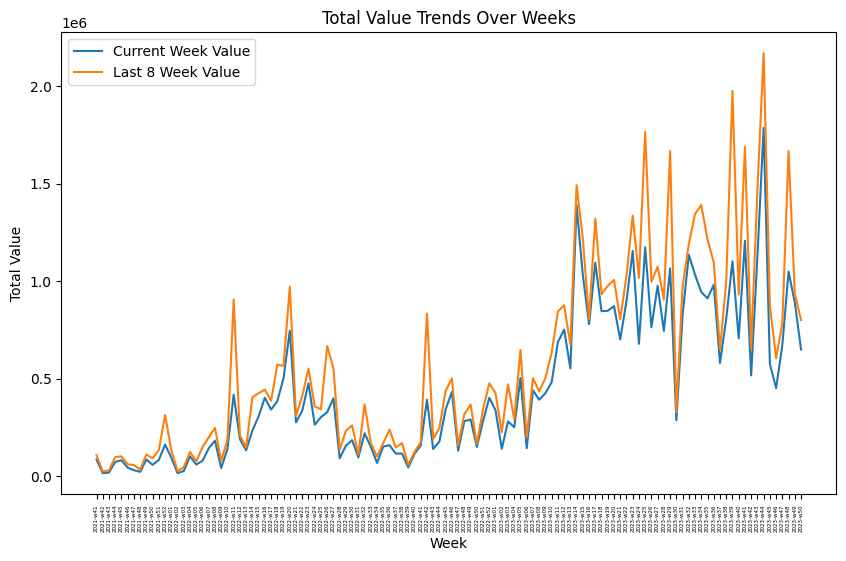

In [58]:
total_value_rows = merged_dataframe[merged_dataframe['Variables'] == 'Total_Value']
# Plot the graph
plt.figure(figsize=(10, 6))

# Plot 'WeekCount' versus 'Current Week Value'
plt.plot(total_value_rows['WeekCount'], total_value_rows['Current Week Value'], label='Current Week Value')

# Plot 'WeekCount' versus 'Last 8 Week Value'
plt.plot(total_value_rows['WeekCount'], total_value_rows['Last 8 Week Value'], label='Last 8 Week Value')

# Set labels and title
plt.xlabel('Week')
plt.ylabel('Total Value')
plt.title('Total Value Trends Over Weeks')
plt.xticks(rotation=90, fontsize=4)
plt.legend()

# Show the plot
plt.show()

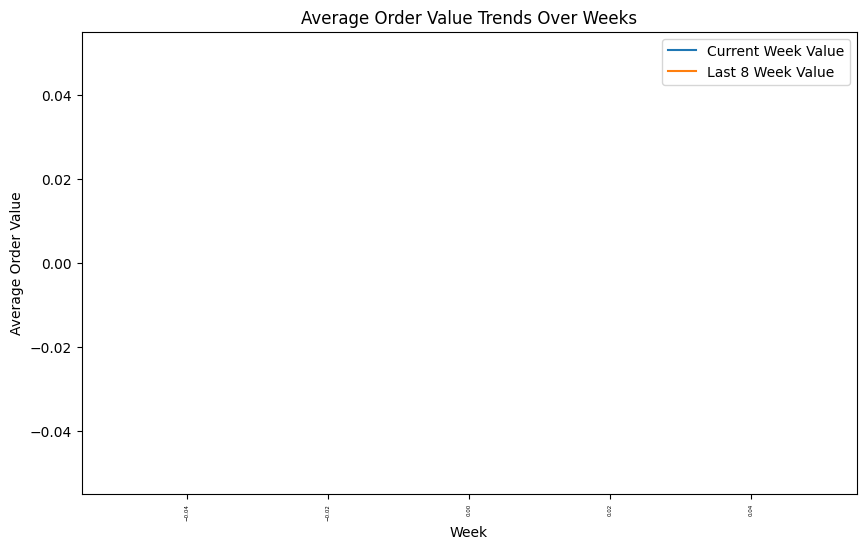

In [59]:
total_value_rows = merged_dataframe[merged_dataframe['Variables'] == 'Average_Order_Value']
# Plot the graph
plt.figure(figsize=(10, 6))

# Plot 'WeekCount' versus 'Current Week Value'
plt.plot(total_value_rows['WeekCount'], total_value_rows['Current Week Value'], label='Current Week Value')

# Plot 'WeekCount' versus 'Last 8 Week Value'
plt.plot(total_value_rows['WeekCount'], total_value_rows['Last 8 Week Value'], label='Last 8 Week Value')

# Set labels and title
plt.xlabel('Week')
plt.ylabel('Average Order Value')
plt.title('Average Order Value Trends Over Weeks')
plt.xticks(rotation=90, fontsize=4)
plt.legend()

# Show the plot
plt.show()

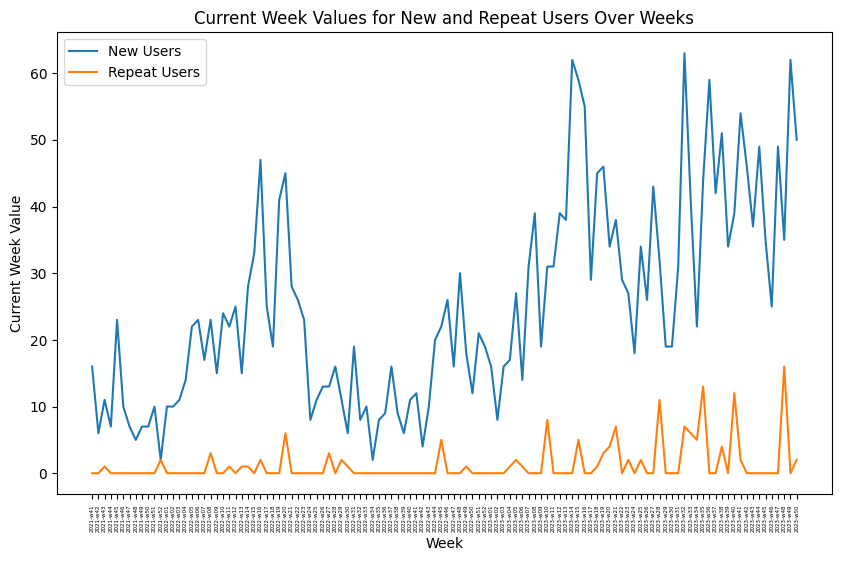

In [60]:
import matplotlib.pyplot as plt

# Filter for 'No_of_New_Users(First_Time_Users)'
new_users_rows = merged_dataframe[merged_dataframe['Variables'] == 'No_of_New_Users(First_Time_Users)']

# Filter for 'No_of_Repeat_Users'
repeat_users_rows = merged_dataframe[merged_dataframe['Variables'] == 'No_of_Repeat_Users']

# Plot the graph
plt.figure(figsize=(10, 6))

# Plot 'WeekCount' versus 'Current Week Value' for New Users
plt.plot(new_users_rows['WeekCount'], new_users_rows['Current Week Value'], label='New Users')

# Plot 'WeekCount' versus 'Current Week Value' for Repeat Users
plt.plot(repeat_users_rows['WeekCount'], repeat_users_rows['Current Week Value'], label='Repeat Users')

# Set labels and title
plt.xlabel('Week')
plt.ylabel('Current Week Value')
plt.title('Current Week Values for New and Repeat Users Over Weeks')
plt.xticks(rotation=90, fontsize=4)
plt.legend()

# Show the plot
plt.show()


In [61]:
# total_value_rows = merged_dataframe[merged_dataframe['Variables'] == 'No_of_Repeat_Users']
# # Plot the graph
# plt.figure(figsize=(10, 6))

# # Plot 'WeekCount' versus 'Current Week Value'
# plt.plot(total_value_rows['WeekCount'], total_value_rows['Current Week Value'], label='Current Week Value')

# # Plot 'WeekCount' versus 'Last 8 Week Value'
# plt.plot(total_value_rows['WeekCount'], total_value_rows['Last 8 Week Value'], label='Last 8 Week Value')

# # Set labels and title
# plt.xlabel('Week')
# plt.ylabel('No_of_Repeat_Users')
# plt.title('No_of_Repeat_Users Trends Over Weeks')
# plt.xticks(rotation=90, fontsize=4)
# plt.legend()

# # Show the plot
# plt.show()

In [62]:
new_df_1

,WeekCount,Variables,Current Week Value,Last 8 Week Value,Tag,User_Cohort_Lables,Product_Cohort_Lables
0,2021-w41,Churned (Single Use Only)-Low Value & Slow Moving,0.0,10698.125000,Secondary_Explanatory,Churned (Single Use Only),Low Value & Slow Moving
1,2021-w41,New-New Business Drivers,51400.0,7496.250000,Secondary_Explanatory,New,New Business Drivers
2,2021-w41,New-Repeat Business Drivers,4200.0,16277.000000,Secondary_Explanatory,New,Repeat Business Drivers
3,2021-w41,Churned (Single Use Only)-Hero,0.0,14264.166667,Secondary_Explanatory,Churned (Single Use Only),Hero
4,2021-w41,Churned (Single Use Only)-High Value & Slow Mo...,0.0,12226.428571,Secondary_Explanatory,Churned (Single Use Only),High Value & Slow Moving
...,...,...,...,...,...,...,...
3410,2023-w50,Champions-High Value & Slow Moving,9294.0,65893.000000,Secondary_Explanatory,Champions,High Value & Slow Moving
3411,2023-w50,Champions-Hero,65893.0,0.000000,Secondary_Explanatory,Champions,Hero
3416,2023-w50,Churned (Repeat Use)-New Business Drivers,0.0,0.000000,Secondary_Explanatory,Churned (Repeat Use),New Business Drivers
3418,2023-w50,New-New Business Drivers,21177.0,37170.750000,Secondary_Explanatory,New,New Business Drivers


In [63]:
# # Group the data by Product Cohort Labels
# grouped_data = new_df_1.groupby('Product_Cohort_Lables')

# # Plot the data for each Product Cohort Label
# plt.figure(figsize=(12, 8))

# for label, group in grouped_data:
#     plt.plot(group['WeekCount'], group['Current Week Value'], label=label)

# plt.xlabel('Week Count')
# plt.ylabel('Current Week Value')
# plt.title('Current Week Value for Each Product Cohort Label')
# plt.legend(title='Product Cohort Labels', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()

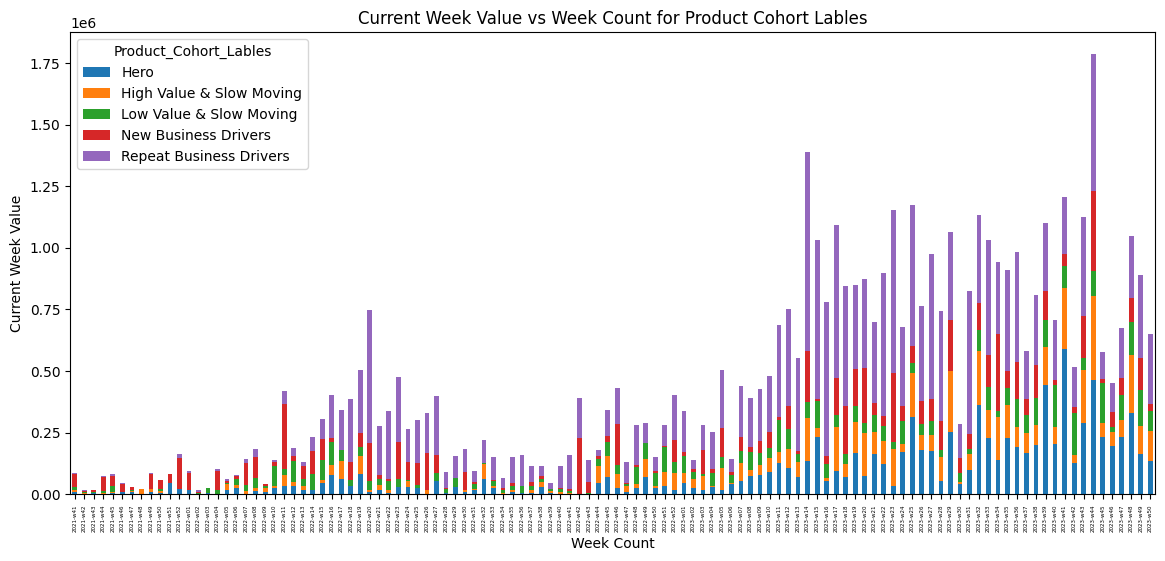

In [64]:
df_agg = new_df_1.groupby(['WeekCount', 'Product_Cohort_Lables'])['Current Week Value'].sum().reset_index()
pivot_df = df_agg.pivot(index='WeekCount', columns='Product_Cohort_Lables', values='Current Week Value')
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title('Current Week Value vs Week Count for Product Cohort Lables')
plt.xlabel('Week Count')
plt.ylabel('Current Week Value')
ax.tick_params(axis='x', labelsize=4)
plt.show()

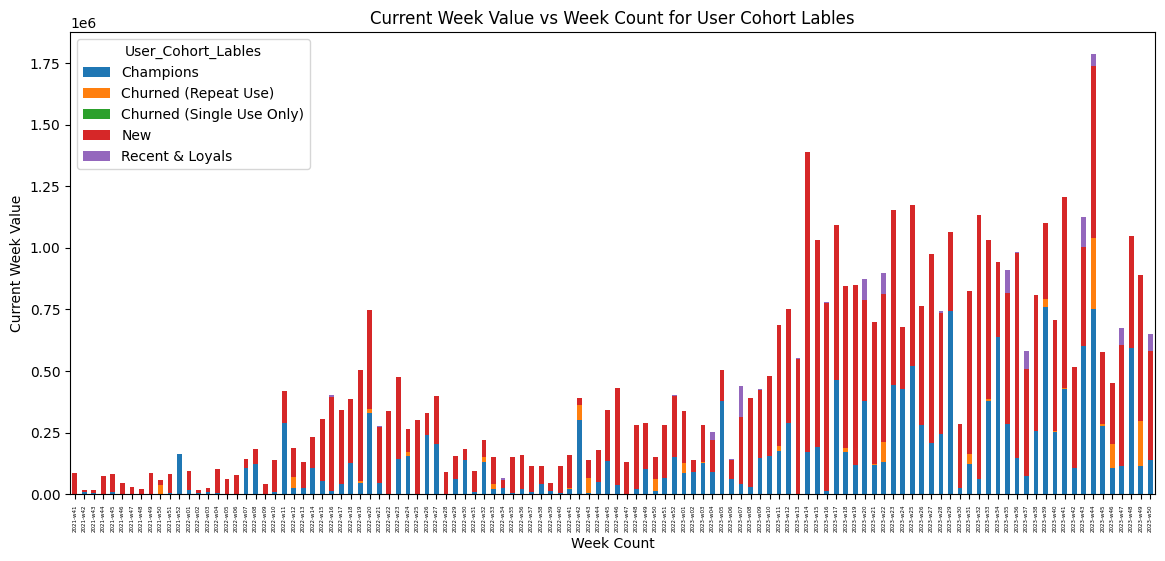

In [65]:
df_agg_user = new_df_1.groupby(['WeekCount', 'User_Cohort_Lables'])['Current Week Value'].sum().reset_index()
pivot_df_user = df_agg_user.pivot(index='WeekCount', columns='User_Cohort_Lables', values='Current Week Value')
ax_user = pivot_df_user.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title('Current Week Value vs Week Count for User Cohort Lables')
plt.xlabel('Week Count')
plt.ylabel('Current Week Value')
ax_user.tick_params(axis='x', labelsize=4)
plt.show()